In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import pydicom
from pydicom.data import get_testdata_files
import imageio
import cv2
from PIL import Image
import numpy as np
import os

In [42]:
patient_count = 345
bmp_lesions = []

for patient_num in range(patient_count+1):
    patient_string = 'Prostatex0{0:0=3d}'.format(patient_num)
    bmp_dirname = 'data/ProstateX_Kyung_lesion_mask/{}/'.format(patient_string)
    if not os.path.exists(bmp_dirname):
        continue
    for bmp_filename in os.listdir(bmp_dirname):
        root, ext = os.path.splitext(bmp_filename)
        if 'ADC' in root and ext == '.bmp':
            lesion_dirname = 'data/ProstateX_Lesion_Seg/{}/study/{}/'.format(patient_string, bmp_filename.split('+')[1])
            for lesion_filename in os.listdir(lesion_dirname):
                root, ext = os.path.splitext(lesion_filename)
                if root.startswith(bmp_filename[:12]) and ext == '.dcm':
                    bmp_lesions.append((lesion_dirname+lesion_filename, bmp_dirname+bmp_filename, patient_string))


In [43]:
def print_dicom(dicom):
    print()
    print("Filename.........:", filename)
    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name...:", display_name)
    print("Patient id.......:", dataset.PatientID)
    print("Modality.........:", dataset.Modality)
    print("Study Date.......:", dataset.StudyDate)
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
    # plot the image using matplotlib
    im = dataset.pixel_array
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()
    return im

In [44]:
def apply_mask(dicom, bmp):
    applied_mask = bmp * dicom_im
    plt.imshow(applied_mask, cmap=plt.cm.bone)
    plt.show()
    

In [45]:
def outline_lesion(im, bmp):
#     plt.imshow(im, cmap=plt.cm.bone)
    ax = plt.gca()

    # Contours
    contours, hierarchy = cv2.findContours(image = bmp, mode = cv2.RETR_TREE, method = cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    c_0 = contours[0] 

    # Get the current reference
    x, y, w, h = cv2.boundingRect(c_0)   
    rect = Rectangle((x, y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

    # Outermost square is 1.4 times the longer rectangle length
    s = max(w, h)*1.4
    s_x = x-(s-w)/2
    s_y = y-(s-h)/2
    square = Rectangle((s_x, s_y),s,s,linewidth=1,edgecolor='y',facecolor='none')
    ax.add_patch(square)

#     plt.show()
    return (s_x, s_y, s)

In [46]:
def crop_lesion(im, bmp):
    pair = outline_lesion(im, bmp)
    s_x = round(pair[0])
    s_y = round(pair[1])
    s = round(pair[2])
    im_crop = im[s_y:s_y+s , s_x:s_x+s]
    return im_crop

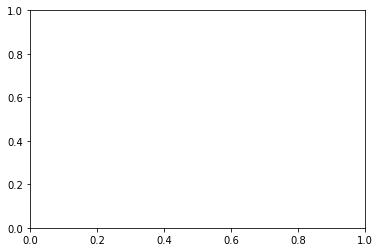

In [47]:
lesions_cropped = []
dicom_arrays = []

for info in bmp_lesions:
    dicom = pydicom.dcmread(info[0])
    bmp = imageio.imread(info[1])
    dicom_im = dicom.pixel_array 
    dicom_arrays.append(dicom_im)
    im_cropped = crop_lesion(dicom_im, bmp)
    name = info[2] + '+' + (os.path.splitext(info[1])[0]).split('/')[-1]
    lesions_cropped.append(im_cropped)
    

In [48]:
normalized = []

def upper_bound(arr, limit):
    for row in arr:
        for item in row:
            if item > 4000:
                print('wtf')
                arr[row][item] = 4000
    return arr

def normalize(arr):
    minval = float(arr.min())
    maxval = float(arr.max())
    ran = maxval - minval
    if ran == 0:
        return None
    return (arr - minval) / ran * 255

for i, img in enumerate(lesions_cropped):
    img_bound = upper_bound(img, 4000)
    img_norm = normalize(img_bound)
    if isinstance(img_norm, np.ndarray):
        normalized.append(img_norm)


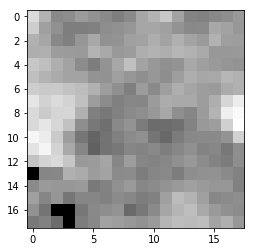

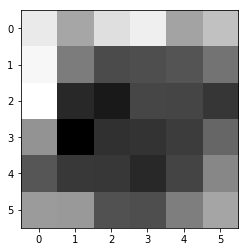

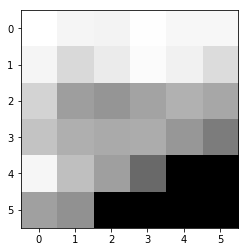

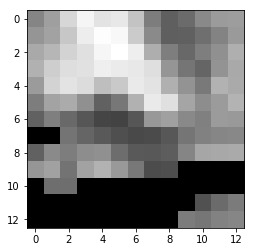

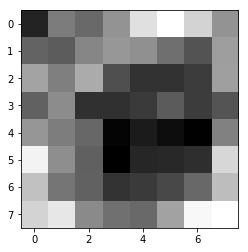

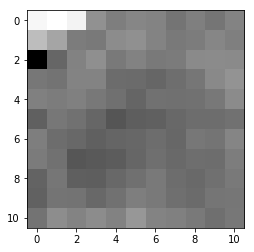

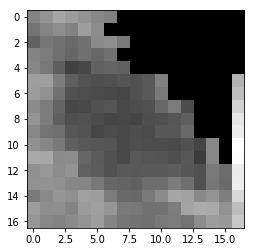

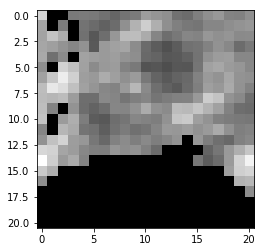

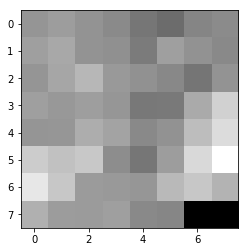

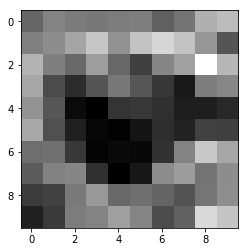

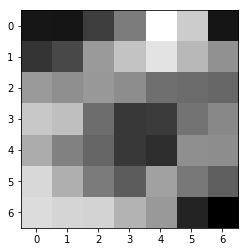

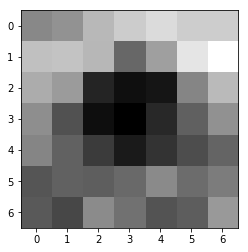

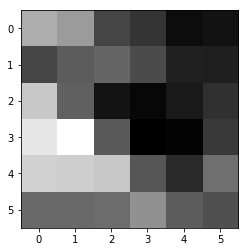

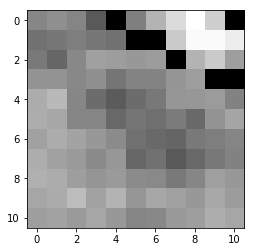

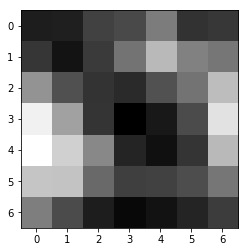

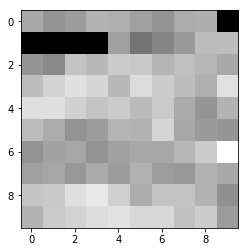

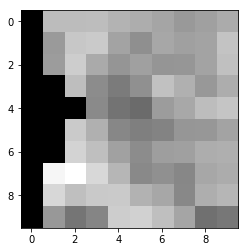

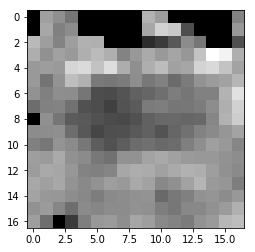

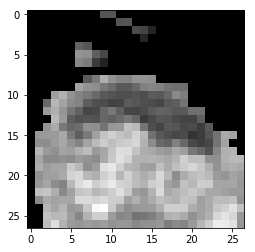

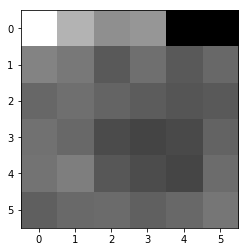

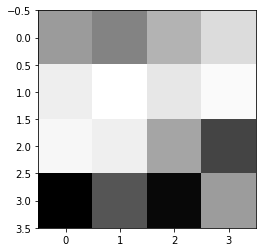

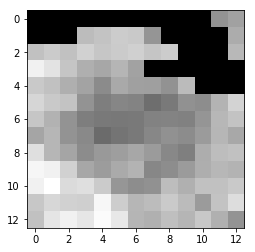

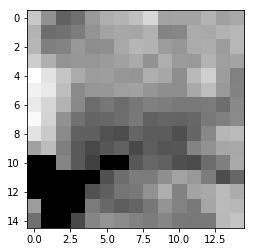

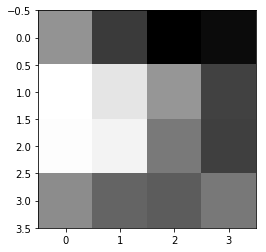

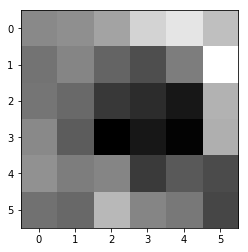

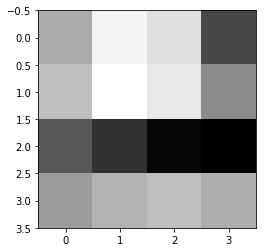

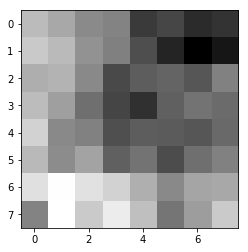

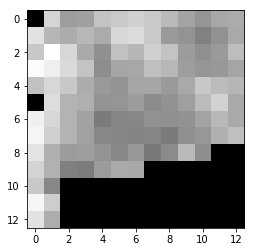

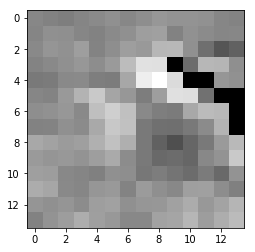

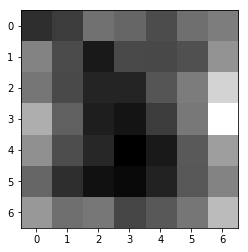

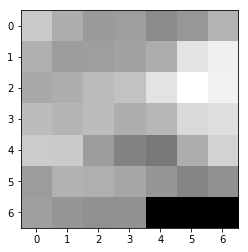

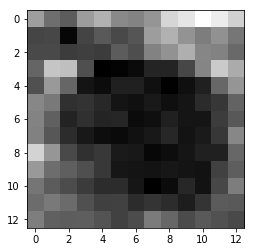

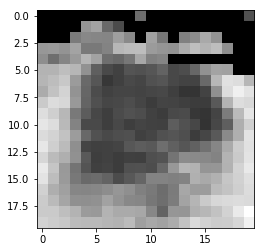

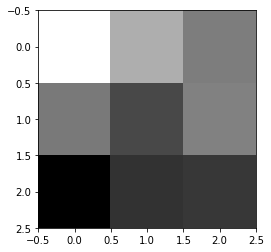

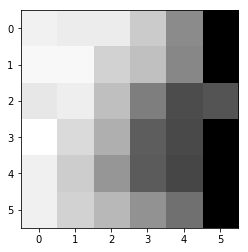

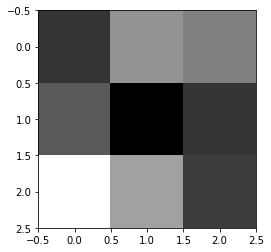

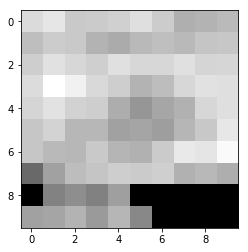

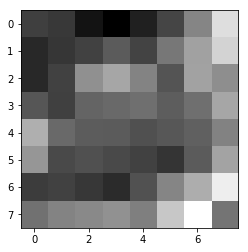

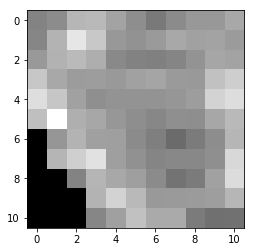

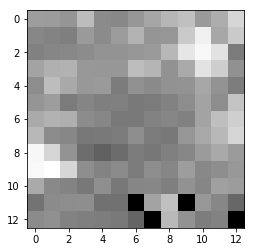

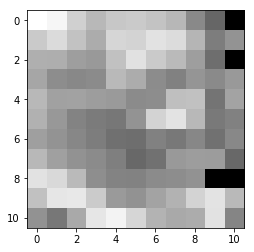

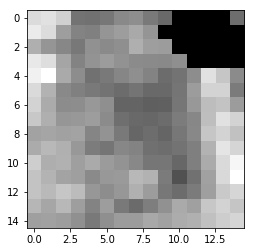

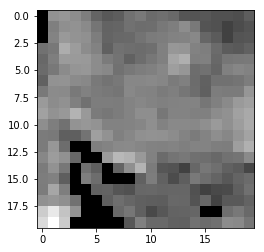

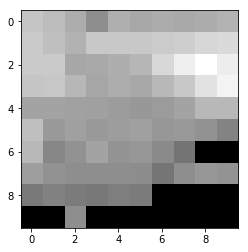

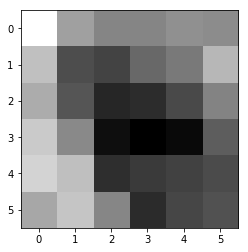

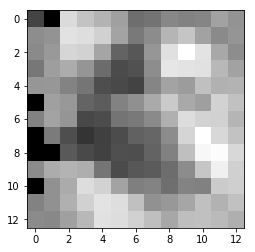

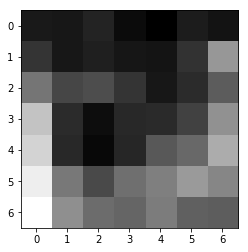

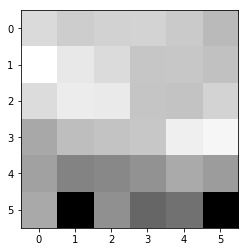

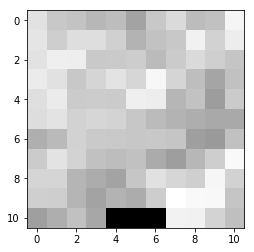

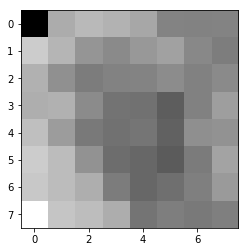

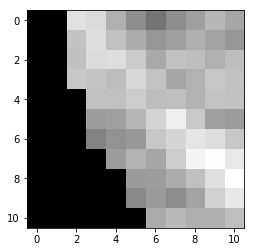

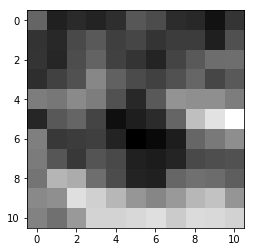

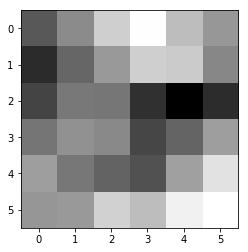

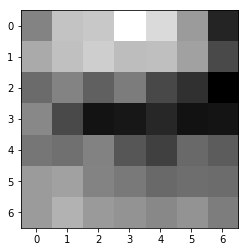

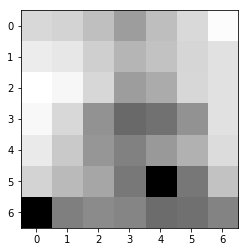

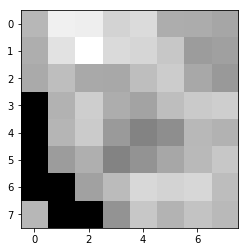

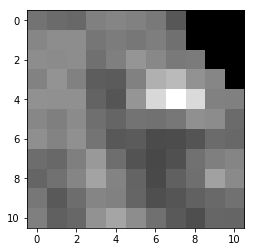

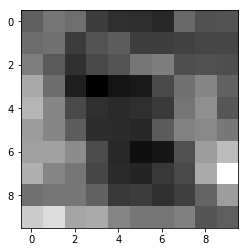

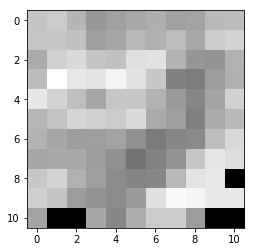

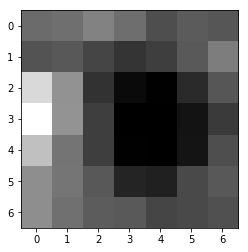

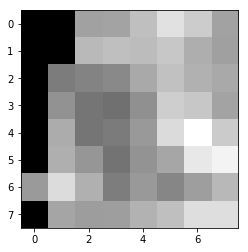

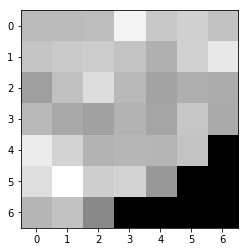

In [ ]:
# Finally, save to file and print
for img in normalized:
    np.save('lesions_cropped/adc_npy/{}.npy'.format(name), im_cropped)
    plt.imshow(img, cmap='gray')
    plt.show()